In [35]:
#install library kaggle untuk download dataset
!pip install kaggle

In [36]:
#buat directory .kaggle
!mkdir .kaggle
!ls -a

mkdir: cannot create directory ‘.kaggle’: File exists
.  ..  .config	.kaggle  sample_data


In [37]:
#buat token untuk bisa akses download dataset
import json, os
token = {"username":"donodanar35","key":"92c113ad1a2fdabc92ea0f3fe5666e90"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

os.listdir('.kaggle/')
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [38]:
#download dataset climate change earth surface dari kaggle
!kaggle datasets download -d berkeleyearth/climate-change-earth-surface-temperature-data -p /tmp

climate-change-earth-surface-temperature-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [39]:
import zipfile,os
local_zip = '/tmp/climate-change-earth-surface-temperature-data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

#ekstra dataset file zip ke destinasi /tmp
zip_ref.extractall('/tmp')
zip_ref.close()

os.listdir('/tmp')

['tmpqsg0xov8.py',
 'GlobalLandTemperaturesByState.csv',
 'GlobalLandTemperaturesByCountry.csv',
 'DailyDelhiClimateTest.csv',
 'daily-climate-time-series-data.zip',
 'GlobalLandTemperaturesByMajorCity.csv',
 'DailyDelhiClimateTrain.csv',
 '__pycache__',
 'climate-change-earth-surface-temperature-data.zip',
 'GlobalLandTemperaturesByCity.csv',
 'tmpzwdkn470.py',
 'tmpsve0sxfa.py',
 'GlobalTemperatures.csv',
 'tmp_al9ftgl.py']

In [40]:
import pandas as pd
import numpy as np
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

df = pd.read_csv('/tmp/GlobalTemperatures.csv')
df = df.drop(['LandAverageTemperatureUncertainty','LandMaxTemperature','LandMaxTemperatureUncertainty','LandMinTemperature','LandMinTemperatureUncertainty','LandAndOceanAverageTemperature','LandAndOceanAverageTemperatureUncertainty'],axis=1)
df

,dt,LandAverageTemperature
0,1750-01-01,3.034
1,1750-02-01,3.083
2,1750-03-01,5.626
3,1750-04-01,8.490
4,1750-05-01,11.573
...,...,...
3187,2015-08-01,14.755
3188,2015-09-01,12.999
3189,2015-10-01,10.801
3190,2015-11-01,7.433


In [41]:
df.isnull().sum()

dt                         0
LandAverageTemperature    12
dtype: int64

In [42]:
#hilangkan baris null dari dataframe
df = df.dropna()
df.notnull().sum()

dt                        3180
LandAverageTemperature    3180
dtype: int64

In [43]:
df.isnull().sum()

dt                        0
LandAverageTemperature    0
dtype: int64

In [44]:
from sklearn.model_selection import train_test_split

#pisahkan dataset training dan dataset validation sebenar 80% dan 20%
dates = df['dt'].values
temp  = df['LandAverageTemperature'].values
temp_latih, temp_val, dates_latih, dates_val = train_test_split(temp, dates, test_size=0.2)


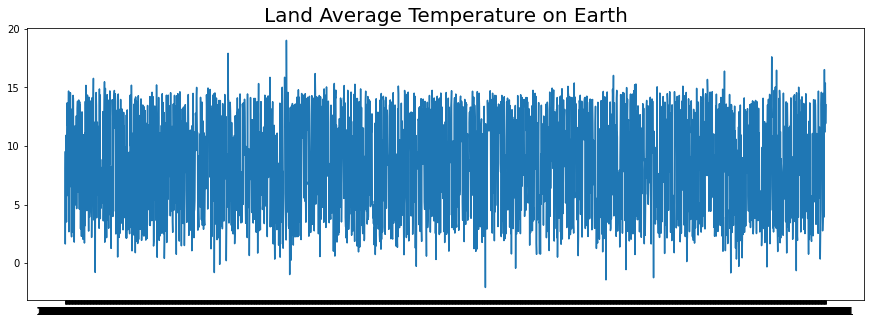

In [45]:
plt.figure(figsize=(15,5))
plt.plot(dates_latih, temp_latih)
plt.title('Land Average Temperature on Earth',
          fontsize=20);

In [46]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

train_set = windowed_dataset(temp_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(temp_val, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(60, return_sequences=True),
      tf.keras.layers.LSTM(60),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1),
])


In [47]:
#buat kelas dan fungsi callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_mae')<4):
      if(logs.get('mae')<4):      
        print("\nMAE data latih dan validation telah mencapai 4%!")
        self.model.stop_training = True
callbacks = myCallback()

optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,validation_data=val_set, epochs=200, callbacks=[callbacks])

Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 3s 113ms/step - loss: 7.9498 - mae: 8.4480 - val_loss: 7.6707 - val_mae: 8.1695
Epoch 2/200
25/25 [==============================] - 2s 86ms/step - loss: 7.7410 - mae: 8.2382 - val_loss: 7.4635 - val_mae: 7.9613
Epoch 3/200
25/25 [==============================] - 2s 86ms/step - loss: 7.5490 - mae: 8.0450 - val_loss: 7.2598 - val_mae: 7.7568
Epoch 4/200
25/25 [==============================] - 2s 86ms/step - loss: 7.3314 - mae: 7.8260 - val_loss: 7.02

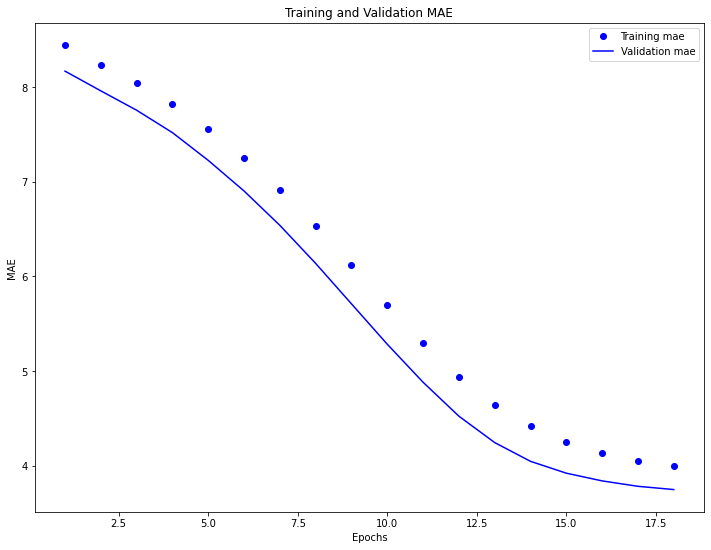

In [50]:
import matplotlib.pyplot as plt

history_dict = history.history

mae=history_dict['mae']
val_mae=history_dict['val_mae']
epochs = range(1, len(mae) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

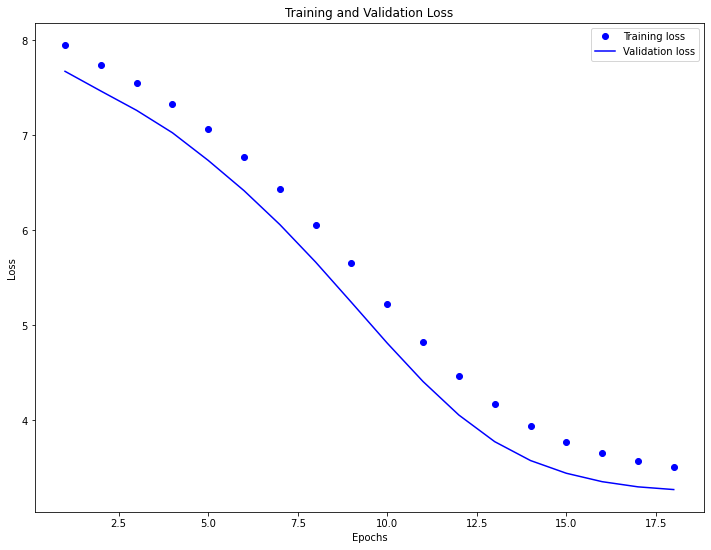

In [51]:
history_dict = history.history
loss=history_dict['loss']
val_loss=history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()